In [1]:
from gymnasium import Env
from gymnasium.spaces.box import Box
import numpy as np
import random
from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import CheckpointCallback, StopTrainingOnRewardThreshold, EvalCallback
from stable_baselines3.common.noise import NormalActionNoise
import wandb
from wandb.integration.sb3 import WandbCallback
import os
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import pickle
import warnings
import math
import pandas as pd
import time
import json
warnings.filterwarnings("ignore")

In [2]:
class Env_5dof(Env):
  """
  Custom Gym Environment for the Hybrid Electromagnetic Suspension, considering all five degrees of freedom.
  """
  def __init__(self, alive = 20, masa_pod = 250, airgap_hems = 15.5, airgap_ems = 10, objetivo_hems = 15.5, objetivo_ems = 10, duration = 10):
    """
    Initialize the environment
    """
    # Actions: Voltage applied to the coil
    self.action_space = Box(low=np.array([-100, -100, -100, -100, -100, -100, -100, -100, -100, -100]), high = np.array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100]), dtype=np.float32)
    # Observations: Airgap to the ceiling, velocity, distance to the objective, current of the coil
    self.observation_space = Box(low=np.array([70.64, 70.64, 70.64, 70.64, 136.8, 136.8, 136.8, 136.8, 70.64, 70.64, 70.64, 70.64, 136.8, 136.8, 136.8, 136.8, -45, -45, -45, -45, -45, -45, -45, -45, -45, -45]), high = np.array([84.14, 84.14, 84.14, 84.14, 148.8, 148.8, 148.8, 148.8, 84.14, 84.14, 84.14, 84.14, 148.8, 148.8, 148.8, 148.8, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45]), dtype=np.float32)
    # Initial parameters
    self.objetivo_hems = objetivo_hems
    self.objetivo_ems = objetivo_ems
    self.airgap_hems = random.choice([14,17]) #airgap_hems
    self.airgap_ems = airgap_ems
    self.duration = duration
    self.timeleft = duration
    self.crash = False
    self.masa_pod = masa_pod
    self.sistema = FiveDOF(masa_pod = self.masa_pod, airgap_hems_inicial = self.airgap_hems, airgap_ems_inicial = self.airgap_ems, objetivo_hems = self.objetivo_hems, objetivo_ems = self.objetivo_ems)
    aux = FiveDOF(masa_pod = self.masa_pod, airgap_hems_inicial = self.objetivo_hems, airgap_ems_inicial = self.objetivo_ems, objetivo_hems = self.objetivo_hems, objetivo_ems = self.objetivo_ems)
    self.objetivo_hems_sensor = [aux.sensors[0]]
    self.objetivo_ems_sensor = [aux.sensors[-1]]
    self.state = np.array([self.sistema.sensors[i] - self.objetivo_hems_sensor[0] for i in range(4)] + [self.sistema.sensors[i+4] - self.objetivo_ems_sensor[0] for i in range(4)] + [self.sistema.sensors[i] - self.objetivo_hems_sensor[0] for i in range(4)] + [self.sistema.sensors[i+4] - self.objetivo_ems_sensor[0] for i in range(4)] + [0 for i in range(10)])
    self.steps = []
    self.alive = alive
    self.prev_error_vertical = sum(self.calculate_error(self.sistema.sensors[i], self.objetivo_hems_sensor[0], self.sistema.altura_maxima, self.sistema.altura_minima) for i in range(4))
    self.prev_error_horizontal = sum(self.calculate_error(self.sistema.sensors[i], self.objetivo_ems_sensor[0], self.sistema.lateral_maxima, self.sistema.lateral_minima) for i in range(4, 8))
    self.prev_error = (self.prev_error_horizontal + self.prev_error_vertical)/8
    self.zposobjective = self.sistema.zposinicial
    self.yposobjective = self.sistema.yposinicial

  def calculate_error(self, airgap: float, objetivo: float, maximo: float, minimo: float) -> float:
    """
    Calculate the error of the airgap
    - airgap: current airgap value (mm)
    - objetivo: objective airgap value (mm)
    - maximo: maximum airgap value (mm)
    - minimo: minimum airgap value (mm)
    """
    return (np.abs(airgap - objetivo)/max(np.abs(maximo - objetivo), np.abs(minimo - objetivo)))**2

  def step(self, action):
    """
    Apply the action to the environment
    """
    # Apply action
    sensors_prev, sensors, currents, self.crash, objetivo_hems, objetivo_ems, zpos, ypos, angley, crash = self.sistema.step([*action])
    self.state = np.array(list(sensors_prev) + list(sensors) + list(currents))

    # Reduce the time of the experiment
    self.timeleft -= 0.001

    # Compute error
    """
    error_hems = sum(self.calculate_error(sensors[i], objetivo_hems, self.sistema.altura_maxima, self.sistema.altura_minima) for i in range(4))
    error_ems = sum(self.calculate_error(sensors[i], objetivo_ems, self.sistema.lateral_maxima, self.sistema.lateral_minima) for i in range(4, 8))
    error = (-2*error_hems - error_ems)/12

    # Compute reward
    reward_raw = 1 + error
    if self.crash: 
      reward_bonus = -0.4
    else:
      if self.prev_error > error: reward_bonus = 0.2
      else: reward_bonus = -0.2

    reward = reward_raw + reward_bonus
    self.prev_error = error"""

    reward = 1 - 0*(np.abs(zpos - self.zposobjective)/7) - 0*(np.abs(ypos - self.yposobjective)/6) - 0*(np.abs(angley)/0.009)



    # Check if experiment is done
    if self.timeleft <= 0:
      truncated = True
    else: truncated = False
    # Set placeholder for info
    info = {}
    # Only if we implemented crash
    if crash:
      terminated = True
    else:
      terminated = False
    self.steps.append(self.state)
    self.objetivo_hems_sensor.append(objetivo_hems); self.objetivo_ems_sensor.append(objetivo_ems)
    return self.state, reward, terminated, truncated, info

  def render(self, yes = "yes", normalize = True, seed = 0):
    """
    Plot the airgap evolution
    """

    # Create a figure and a set of subplots
    fig = plt.figure(figsize=(20,10))
    x = list(range(0,len(self.steps)))

    # Plot the airgap evolution of the HEMS
    ax = fig.add_subplot(2, 2, 1)
    if normalize: ax.set_ylim(bottom=self.sistema.altura_minima - 1, top=self.sistema.altura_maxima + 2)
    plt.xlabel("Time (ms)") #, color='white')
    plt.ylabel("Airgap (mm)") #, color='white')
    plt.title("HEMS Airgap Evolution") #, color='white')
    for i in range(4):
      y = [step[i + 8] for j, step in enumerate(self.steps)]
      ax.plot(x, y, label = "Airgap HEMS " + str(i + 1))
    objective = self.objetivo_hems_sensor[1:]
    ax.plot(x, objective, label = "Objective HEMS")
    ax.legend()
    
    # Plot the airgap evolution of the EMS
    ax = fig.add_subplot(2, 2, 2)
    if normalize: ax.set_ylim(bottom=self.sistema.lateral_minima -1, top=self.sistema.lateral_maxima + 2)
    plt.xlabel("Time (ms)") #, color='white')
    plt.ylabel("Airgap (mm)") #, color='white')
    plt.title("EMS Airgap Evolution") #, color='white')
    
    for i in range(4):
      y = [step[i + 12] for step in self.steps]
      ax.plot(x, y, label = "Airgap EMS " + str(i + 1))
    objective = self.objetivo_ems_sensor[1:]
    ax.plot(x, objective, label = "Objective EMS")
    ax.legend()

    # Plot the current evolution of the HEMS
    ax = fig.add_subplot(2, 2, 3)
    if normalize: ax.set_ylim(bottom=-50, top=50)
    plt.xlabel("Time (ms)") #, color='white')
    plt.ylabel("Current (A)") #, color='white')
    plt.title("HEMS Current Evolution") #, color='white')
    
    for i in range(4):
      y = [step[i + 16] for step in self.steps]
      ax.plot(x, y, label = "Current HEMS " + str(i + 1))
    objective = [0]*len(self.steps)
    ax.plot(x, objective, label = "Objective Current HEMS")
    ax.legend()

    # Plot the current evolution of the EMS
    ax = fig.add_subplot(2, 2, 4)
    if normalize: ax.set_ylim(bottom=-50, top=50)
    plt.xlabel("Time (ms)") #, color='white')
    plt.ylabel("Current (A)") #, color='white')
    plt.title("EMS Current Evolution") #, color='white')
    
    for i in range(6):
      y = [step[i + 20] for step in self.steps]
      ax.plot(x, y, label = "Current EMS " + str(i + 1))
    objective = [0]*len(self.steps)
    ax.plot(x, objective, label = "Objective Current EMS")
    ax.legend()

    plt.savefig(f"images/5dof-{seed}.png")
    plt.show()

  def reset(self, seed = 0):
    """
    Reset experiment
    """
    # Reset experiment choosing randomly the start (ceiling or floor)
    self.airgap_hems = random.choice([14,17])
    self.state = np.array([self.airgap_hems - self.objetivo_hems for i in range(4)] + [self.airgap_ems - self.objetivo_ems for i in range(4)] + [self.airgap_hems - self.objetivo_hems for i in range(4)] + [self.airgap_ems - self.objetivo_ems for i in range(4)] + [0 for i in range(10)])
    self.sistema = FiveDOF(masa_pod = self.masa_pod, airgap_hems_inicial = self.airgap_hems, airgap_ems_inicial = self.airgap_ems, objetivo_hems = self.objetivo_hems, objetivo_ems = self.objetivo_ems)
    
    self.objetivo_hems_sensor = [self.objetivo_hems_sensor[0]]
    self.objetivo_ems_sensor = [self.objetivo_ems_sensor[0]]
    self.prev_error_vertical = sum(self.calculate_error(self.sistema.sensors[i], self.objetivo_hems_sensor[0], self.sistema.altura_maxima, self.sistema.altura_minima) for i in range(4))
    self.prev_error_horizontal = sum(self.calculate_error(self.sistema.sensors[i], self.objetivo_ems_sensor[0], self.sistema.lateral_maxima, self.sistema.lateral_minima) for i in range(4, 8))
    self.prev_error = (self.prev_error_horizontal + self.prev_error_vertical)/8
    # Reset time
    self.timeleft = self.duration
    self.crash = False
    self.steps = []
    return self.state, seed

In [3]:
class HEMS():
  """ 
  Coil model for the Hybrid Electromagnetic Suspension
  """
  def __init__(self, masa_pod = 250, airgap = 22.5, min_distance = 9, max_distance = 22.5, L_hems = None, fv_hems = None):
    self.masa_pod = masa_pod
    self.airgap = airgap
    self.aceleracion = []
    self.velocidad = []
    mat = scipy.io.loadmat('./coil/hems.mat')
    self.hems = mat["hems"][0][0]
    self.airgaps = self.hems[0][0]
    self.currents = self.hems[1][0]
    #self.force_vertical = pickle.load(open("./coil/mlp_vertical.pkl", 'rb'))
    #self.force_horizontal = pickle.load(open("./coil/rf_horizontal.pkl", 'rb'))
    self.flux = self.hems[3]
    #self.inductance = pickle.load(open("./coil/rf_inductance.pkl", 'rb'))
    self.resistance = self.hems[6][0][0]
    self.min_distance = min_distance
    self.max_distance = max_distance
    self.airgapinicial = airgap
    self.crash = False
    self.current = 0
    self.steps_RL = [0]
    self.integralRL = [0]
    self.L_hems = L_hems
    self.fv_hems = fv_hems
     

  def integral(self, lista, h = 1):
    return sum(h*(lista[i]+lista[i+1])/2 for i in range(len(lista)-1))
  
  def fast_integral(self, last: float, lista: list, h: float = 0.001) -> float:
        """
        Calculate the integral of a list of values
        - last: last value of the integral
        - lista: list of values to integrate
        - h: step of the integral
        """
        return last + h*(lista[-1]+lista[-2])/2

  def RL(self, airgap, target_voltage, temperature):
    # Resistance-Inductance circuit

    # Get resistance of the coil
    R = self.resistance  #self.R(current = self.current, temperature = temperature)   
    V = target_voltage
    I = self.current
    L = self.L(airgap = airgap, current = self.current)
    dIdt = ((V/R) - I)/(L/R)                                      
    self.steps_RL.append(dIdt)                                   
    #current = self.integral(self.steps_RL, h = 0.001)  
    current = self.fast_integral(self.integralRL[-1], self.steps_RL, 0.001)
    self.integralRL.append(current)         
    return current   

  def RL2(self, airgap, target_voltage, temperature, L):
    # Resistance-Inductance circuit

    # Get resistance of the coil
    R = self.resistance  #self.R(current = self.current, temperature = temperature)   
    V = target_voltage
    I = self.current
    dIdt = ((V/R) - I)/(L/R)                                      
    self.steps_RL.append(dIdt)                                   
    #current = self.integral(self.steps_RL, h = 0.001)  
    current = self.fast_integral(self.integralRL[-1], self.steps_RL, 0.001)
    self.integralRL.append(current)         
    return current                                                

  def R(self, current, temperature):
    return self.resistance                                         

  def L(self, airgap, current):
    # Return predicted inductance
    #return float(self.inductance.predict(np.array([[airgap, current]]))[0])
    if airgap < 8: airgap = 8
    elif airgap > 22.5: airgap = 22.5
    return self.L_hems[str(float(round(airgap, 1)))][str(float(round(current, 1)+ 0))]
  
  def get_current(self, airgap, target_voltage, temperature):
    # Get current from RL circuit
    I = self.RL(airgap = airgap, target_voltage = target_voltage, temperature = temperature) 
    
    # Clip result
    if I > 45:
      I = 45
    elif I < -45:
      I = -45
    self.current = I                  
    return I

  def vertical_force(self, airgap, target_voltage, temperature):
    # Get current from RL circuit
    I = self.RL(airgap = airgap, target_voltage = target_voltage, temperature = temperature) 
    
    # Clip result
    if I > 45:
      I = 45
    elif I < -45:
      I = -45
    self.current = I
    # Get vertical force from 
    FI = self.FI_vertical(airgap = airgap, current = I)                    
    return FI, I
  
  def horizontal_force(self, airgap, target_voltage, temperature):
    # Get current from RL circuit
    I = self.RL(airgap = airgap, target_voltage = target_voltage, temperature = temperature) 
    
    # Clip result
    if I > 45:
      I = 45
    elif I < -45:
      I = -45
    self.current = I
    # Get vertical force from 
    FI = self.FI_horizontal(airgap = airgap, current = I)                    
    return FI, I

  def FI_vertical(self, airgap, current):
    # Return predicted vertical force
    #return float(self.force_vertical.predict(np.array([[airgap, current]])))  
    if airgap < 8: airgap = 8
    elif airgap >22.5: airgap= 22.5
    return self.fv_hems[str(float(round(airgap, 1)))][str(float(round(current, 1)+ 0))]

  def FI_horizontal(self, airgap, current):
    # Return predicted vertical force
    return 0  

  def next_airgap(self, masa_pod, vertical_force, verbose = False):
    # Devide the mass of the pod by 4 coils
    masa = masa_pod/4  
    # Calculate weight
    peso = masa * 9.8    
    # Get total force                                                       
    fuerza = peso - vertical_force
    if verbose: print("Fuerza resultante: ", fuerza)   
    # Calculate acceleration                                     
    aceleracion = fuerza/masa
    if verbose: print("Aceleración: ", aceleracion)                                         
    self.aceleracion.append(aceleracion)       
    # Calculate velocity                                
    velocidad = self.integral(self.aceleracion, 0.001)
    if verbose: print("Integral primera (velocidad): ", velocidad)                          
    self.velocidad.append(velocidad)               
    # Calculate position (x1000 as to transform from m to mm)                            
    posicion = self.airgapinicial + self.integral(self.velocidad, 0.001)*1000 
    if verbose: print("Integral segunda (posición): ", posicion)

    # Clip position
    if posicion > self.max_distance:
      airgap = self.max_distance
      self.aceleracion = [0]
      self.velocidad = [0]  
      #self.crash = True     
      self.airgapinicial = self.max_distance                                               
    elif posicion < self.min_distance:
      airgap = self.min_distance
      self.aceleracion = [0]
      self.velocidad = [0]
      #self.crash = True
      self.airgapinicial = self.min_distance
    else: airgap = posicion
    return airgap, velocidad

  def step(self, target_voltage, verbose = False):
    # Calculate vertical force and current
    vertical_force, self.current = self.vertical_force(airgap = self.airgap, target_voltage = target_voltage, temperature = 40)
    if verbose: print("Fuerza vertical: ", vertical_force)
    # Calculate next airgap and velocity
    self.airgap, velocidad = self.next_airgap(self.masa_pod, vertical_force, verbose = verbose)
    #noise = np.random.normal(0,0.5)
    #self.airgap = self.airgap + noise     
    return (np.float32(self.airgap), np.float32(velocidad), np.float32(self.airgap - 16.3), np.float32(self.current)), self.crash

In [4]:
class EMS():
  """ 
  Coil model for the Hybrid Electromagnetic Suspension
  """
  def __init__(self, masa_pod = 250, airgap = 22.5, min_distance = 9, max_distance = 22.5, L_ems = None, fh_ems = None):
    self.masa_pod = masa_pod
    self.airgap = airgap
    self.aceleracion = []
    self.velocidad = []
    df = pd.read_excel('./coil/ems.xlsx')
    #self.force_horizontal = pickle.load(open("./coil/rf_ems.pkl", 'rb'))
    #self.inductance = pickle.load(open("./coil/rf_inductance.pkl", 'rb'))
    self.resistance = 0.8050
    self.min_distance = min_distance
    self.max_distance = max_distance
    self.airgapinicial = airgap
    self.crash = False
    self.current = 0
    self.steps_RL = [0]
    self.integralRL = [0]
    self.L_ems = L_ems
    self.fh_ems = fh_ems

  def integral(self, lista, h = 1):
    return sum(h*(lista[i]+lista[i+1])/2 for i in range(len(lista)-1))
  
  def fast_integral(self, last: float, lista: list, h: float = 0.001) -> float:
        """
        Calculate the integral of a list of values
        - last: last value of the integral
        - lista: list of values to integrate
        - h: step of the integral
        """
        return last + h*(lista[-1]+lista[-2])/2

  def RL(self, airgap, target_voltage, temperature):
    # Resistance-Inductance circuit

    # Get resistance of the coil
    R = self.resistance  #self.R(current = self.current, temperature = temperature)   
    V = target_voltage
    I = self.current
    L = self.L(airgap = airgap, current = self.current)
    dIdt = ((V/R) - I)/(L/R)                                      
    self.steps_RL.append(dIdt)                                   
    #current = self.integral(self.steps_RL, h = 0.001)  
    current = self.fast_integral(self.integralRL[-1], self.steps_RL, 0.001)
    self.integralRL.append(current)           
    return current    

  def RL2(self, airgap, target_voltage, temperature, L):
    # Resistance-Inductance circuit

    # Get resistance of the coil
    R = self.resistance  #self.R(current = self.current, temperature = temperature)   
    V = target_voltage
    I = self.current
    dIdt = ((V/R) - I)/(L/R)                                      
    self.steps_RL.append(dIdt)                                   
    #current = self.integral(self.steps_RL, h = 0.001)  
    current = self.fast_integral(self.integralRL[-1], self.steps_RL, 0.001)
    self.integralRL.append(current)         
    return current                                                

  def R(self, current, temperature):
    return self.resistance                                         

  def L(self, airgap, current):
    # Return predicted inductance
    #return float(self.inductance.predict(np.array([[airgap, current]]))[0])
    return self.L_ems[str(float(round(airgap, 1)))][str(float(round(current, 1)+ 0))]
  
  def get_current(self, airgap, target_voltage, temperature):
    # Get current from RL circuit
    I = self.RL(airgap = airgap, target_voltage = target_voltage, temperature = temperature) 
    
    # Clip result
    if I > 45:
      I = 45
    elif I < 0:
      I = 0
    self.current = I                  
    return I

  def vertical_force(self, airgap, target_voltage, temperature):
    # Get current from RL circuit
    I = self.RL(airgap = airgap, target_voltage = target_voltage, temperature = temperature) 
    
    # Clip result
    if I > 45:
      I = 45
    elif I < 0:
      I = 0
    self.current = I
    # Get vertical force from 
    FI = self.FI_vertical(airgap = airgap, current = I)                    
    return FI, I
  
  def horizontal_force(self, airgap, target_voltage, temperature):
    # Get current from RL circuit
    I = self.RL(airgap = airgap, target_voltage = target_voltage, temperature = temperature) 
    
    # Clip result
    if I > 45:
      I = 45
    elif I < -45:
      I = -45
    self.current = I
    # Get vertical force from 
    FI = self.FI_horizontal(airgap = airgap, current = np.abs(I))                    
    return FI, I

  def FI_vertical(self, airgap, current):
    # Return predicted vertical force
    return 0  

  def FI_horizontal(self, airgap, current):
    # Return predicted vertical force
    #return float(self.force_horizontal.predict(np.array([[airgap, current]]))[0])  
    return self.fh_ems[str(float(round(airgap, 1)))][str(float(round(current, 1)+ 0))]

  def next_airgap(self, masa_pod, vertical_force, verbose = False):
    # Devide the mass of the pod by 4 coils
    masa = masa_pod/4  
    # Calculate weight
    peso = masa * 9.8    
    # Get total force                                                       
    fuerza = peso - vertical_force
    if verbose: print("Fuerza resultante: ", fuerza)   
    # Calculate acceleration                                     
    aceleracion = fuerza/masa
    if verbose: print("Aceleración: ", aceleracion)                                         
    self.aceleracion.append(aceleracion)       
    # Calculate velocity                                
    velocidad = self.integral(self.aceleracion, 0.001)
    if verbose: print("Integral primera (velocidad): ", velocidad)                          
    self.velocidad.append(velocidad)               
    # Calculate position (x1000 as to transform from m to mm)                            
    posicion = self.airgapinicial + self.integral(self.velocidad, 0.001)*1000 
    if verbose: print("Integral segunda (posición): ", posicion)

    # Clip position
    if posicion > self.max_distance:
      airgap = self.max_distance
      self.aceleracion = [0]
      self.velocidad = [0]  
      #self.crash = True     
      self.airgapinicial = self.max_distance                                               
    elif posicion < self.min_distance:
      airgap = self.min_distance
      self.aceleracion = [0]
      self.velocidad = [0]
      #self.crash = True
      self.airgapinicial = self.min_distance
    else: airgap = posicion
    return airgap, velocidad

  def step(self, target_voltage, verbose = False):
    # Calculate vertical force and current
    vertical_force, self.current = self.vertical_force(airgap = self.airgap, target_voltage = target_voltage, temperature = 40)
    if verbose: print("Fuerza vertical: ", vertical_force)
    # Calculate next airgap and velocity
    self.airgap, velocidad = self.next_airgap(self.masa_pod, vertical_force, verbose = verbose)
    #noise = np.random.normal(0,0.5)
    #self.airgap = self.airgap + noise     
    return (np.float32(self.airgap), np.float32(velocidad), np.float32(self.airgap - 16.3), np.float32(self.current)), self.crash

In [5]:
class FiveDOF():
    def __init__(self, masa_pod = 250, airgap_hems_inicial = 15.5, airgap_ems_inicial = 10, objetivo_hems = 15.5, objetivo_ems = 10) -> None:
        """
        Initialize the system
        - masa_pod: mass of the vehicle (kg)
        - airgap_hems_inicial: initial airgap of the HEMS (mm)
        - airgap_ems_inicial: initial airgap of the EMS (mm)
        - objetivo_hems: objective airgap of the HEMS (mm)
        - objetivo_ems: objective airgap of the EMS (mm)
        """
        self.masa = 250 # kg
        self.objetivo_hems = objetivo_hems # mm
        self.objetivo_ems = objetivo_ems # mm
        self.inertiax, self.inertiay, self.inertiaz = 43.082, 26.887, 29.297 # kg*m^2
        self.espesor_L = 15 # mm
        self.dist = {
            "x": {
                "HEMS": {"pos": 0.6475, "neg": -0.6475}, # m
                "EMS": {"pos": 0.788, "neg": -0.788, "zero": 0}, # m
                "sensor": {1: 1.0093, 2: 1.0093, 3: -1.0093, 4: -1.0093, 5: 1.0095, 6: 1.0095, 7: -1.0095, 8: -1.0095} # m
            },
            "y": {
                "HEMS": {"pos": 0.191, "neg": -0.191}, # m
                "EMS": {"pos": 0.268, "neg": -0.268}, # m
                "sensor": {1: -0.21748, 2: 0.21748, 3: -0.21748, 4: 0.21748, 5: -0.1347, 6: 0.1347, 7: -0.1347, 8: 0.1347} # m
            },
            "z": {
                "HEMS": 0.05405, # m
                "EMS": 0.20255, # m
                "sensor": {1: -0.05499, 2: -0.05499, 3: -0.05499, 4: -0.05499, 5: 0.18782, 6: 0.18782, 7: 0.18782, 8: 0.18782} # m
            }
        }
        self.zposinicial = - self.dist["z"]["HEMS"]*1000 + airgap_hems_inicial # mm
        self.yposinicial = self.dist["y"]["EMS"]["pos"]*1000 + airgap_ems_inicial # mm
        self.horizontal_distance = 556 # mm
        self.altura_maxima, self.altura_minima = 84.14, 70.64 # mm
        self.altura_maxima_hems, self.altura_minima_hems = 22.5, 9 # mm
        self.lateral_maxima, self.lateral_minima = 148.8, 136.8 # mm
        self.lateral_maxima_ems, self.lateral_minima_ems = 16, 4 # mm
        self.objetivo_sensors_hems = self.get_airgap_sensors_hems(0, 0, - self.dist["z"]["HEMS"]*1000 + objetivo_hems)[0] # mm
        self.objetivo_sensors_ems = self.get_airgap_sensors_ems(0, 0, self.dist["y"]["EMS"]["pos"]*1000 + objetivo_ems)[0] # mm


        self.alphax, self.alphay, self.alphaz = [0], [0], [0]
        self.omegax, self.omegay, self.omegaz = [0], [0], [0]
        self.angulox, self.anguloy, self.anguloz = [0], [0], [0]
        self.aceleracion_z, self.velocidad_z, self.posicion_z = [0], [0], [0]
        self.aceleracion_y, self.velocidad_y, self.posicion_y = [0], [0], [0]
        self.altura, self.lateral = [], []
        self.Fz = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        self.Fy = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        self.current = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

        airgaps_sensors_hems = self.get_airgap_sensors_hems(self.angulox[0], self.anguloy[0], self.zposinicial)
        airgaps_sensors_ems = self.get_airgap_sensors_ems(self.angulox[0], self.anguloz[0], self.yposinicial)
        airgaps_hems = self.get_airgap_hems(self.angulox[0], self.anguloy[0], self.zposinicial)
        airgaps_ems = self.get_airgap_ems(self.angulox[0], self.anguloz[0], self.yposinicial)
        self.sensors = list(airgaps_sensors_hems) + list(airgaps_sensors_ems)
        self.sensors_prev = self.sensors.copy()
        self.airgap = list(airgaps_hems) + list(airgaps_ems)
        
        with open('./coil/L_ems.json') as json_file:
            self.L_ems = json.load(json_file)
        with open('./coil/fh_ems.json') as json_file:
            self.fh_ems = json.load(json_file)
        
        with open('./coil/L_hems.json') as json_file:
            self.L_hems = json.load(json_file)
        with open('./coil/fv_hems.json') as json_file:
            self.fv_hems = json.load(json_file)
        self.bobinas = [HEMS(masa_pod = self.masa, airgap = self.airgap[i], min_distance = self.altura_minima_hems, max_distance = self.altura_maxima_hems, L_hems=self.L_hems, fv_hems=self.fv_hems) for i in range(4)] +[EMS(masa_pod = self.masa, airgap = self.airgap[i], min_distance = self.lateral_minima_ems, max_distance = self.lateral_maxima_ems, L_ems=self.L_ems, fh_ems=self.fh_ems) for i in range(4, 10)]
        self.crash = False
        self.error = [np.float32(x - self.objetivo_sensors_hems) for x in airgaps_sensors_hems] + [np.float32(x - self.objetivo_sensors_ems) for x in airgaps_sensors_ems]
        self.error_prev = self.error.copy()
 
    def integral(self, lista: list, h: float = 1) -> float:
        """
        Calculate the integral of a list of values
        - lista: list of values to integrate
        - h: step of the integral
        """
        return sum(h*(lista[i]+lista[i+1])/2 for i in range(len(lista)-1))
    
    def fast_integral(self, last: float, lista: list, h: float = 0.001) -> float:
        """
        Calculate the integral of a list of values
        - last: last value of the integral
        - lista: list of values to integrate
        - h: step of the integral
        """
        return last + h*(lista[-1]+lista[-2])/2
    
    def momento_x(self, Fy: list, Fz: list) -> float:
        """
        Calculate the momentum in the x axis
        - Fy: list of the horizontal forces of the levitation units
        - Fz: list of the vertical forces of the levitation units
        """
        return (self.dist["y"]["HEMS"]["pos"] * (-Fz[4 - 1] - Fz[2 - 1]) +
                self.dist["y"]["HEMS"]["neg"] * (-Fz[3 - 1] - Fz[1 - 1]) +
                self.dist["z"]["EMS"] * (Fy[10 - 1] + Fy[8 - 1] + Fy[6 - 1] - Fy[9 - 1] - Fy[7 - 1] - Fy[5 - 1]) +
                self.dist["z"]["HEMS"] * (Fy[4 - 1] + Fy[2 - 1] - Fy[3 - 1] - Fy[1 - 1]))
    
    def momento_y(self, Fz: list) -> float:
        """
        Calculate the momentum in the y axis
        - Fz: list of the vertical forces of the levitation units
        """
        return (self.dist["x"]["HEMS"]["pos"] * (- Fz[2 - 1] - Fz[1 - 1]) + 
                self.dist["x"]["HEMS"]["neg"] * (- Fz[4 - 1] - Fz[3 - 1]))
    
    def momento_z(self, Fy: list) -> float:
        """
        Calculate the momentum in the z axis
        - Fy: list of the horizontal forces of the levitation units
        """
        return (self.dist["x"]["HEMS"]["pos"] * (- Fy[1 - 1] + Fy[2 - 1]) +
                self.dist["x"]["EMS"]["pos"] * (- Fy[5 - 1] + Fy[6 - 1]) +
                self.dist["x"]["HEMS"]["neg"] * (- Fy[3 - 1] + Fy[4 - 1]) +
                self.dist["x"]["EMS"]["neg"] * (- Fy[9 - 1] + Fy[10 - 1]))
    
    def get_angulos(self, Mx: float, My: float, Mz: float) -> tuple:
        """
        Calculate the angles of the vehicle in the x, y and z axis
        - Mx: momentum in the x axis
        - My: momentum in the y axis
        - Mz: momentum in the z axis
        """
        alphax, alphay, alphaz = Mx/self.inertiax, My/self.inertiay, Mz/self.inertiaz
        self.alphax.append(alphax); self.alphay.append(alphay); self.alphaz.append(alphaz)
        omegax, omegay, omegaz = self.fast_integral(self.omegax[-1], self.alphax, 0.001), self.fast_integral(self.omegay[-1], self.alphay, 0.001), self.fast_integral(self.omegaz[-1], self.alphaz, 0.001)
        self.omegax.append(omegax); self.omegay.append(omegay); self.omegaz.append(omegaz)
        angulox, anguloy, anguloz = self.fast_integral(self.angulox[-1], self.omegax, 0.001), self.fast_integral(self.anguloy[-1], self.omegay, 0.001), self.fast_integral(self.anguloz[-1], self.omegaz, 0.001)
        self.angulox.append(angulox); self.anguloy.append(anguloy); self.anguloz.append(anguloz)
        return angulox, anguloy, anguloz

    def get_zpos(self, Fz: list) -> float:
        """
        Calculate the position of the center of mass of the vehicle in the z axis
        - Fz: list of the vertical forces of the levitation units
        """
        P = self.masa * 9.8
        F = P - sum(f for f in Fz)
        a = F/self.masa
        self.aceleracion_z.append(a)
        v = self.fast_integral(self.velocidad_z[-1], self.aceleracion_z, 0.001)
        self.velocidad_z.append(v)
        zpos = self.fast_integral(self.posicion_z[-1],self.velocidad_z, 0.001)
        self.posicion_z.append(zpos)
        zpos = self.zposinicial + zpos*1000 # mm
        self.altura.append(zpos)
        return zpos # mm
    
    def get_ypos(self, Fy: list) -> float:
        """
        Calculate the position of the center of mass of the vehicle in the y axis
        - Fy: list of the horizontal forces of the levitation units
        """
        F = sum(f for i, f in enumerate(Fy) if (i+1)%2 == 0) - sum(f for i, f in enumerate(Fy) if (i+1)%2 != 0)
        a = -F/self.masa
        self.aceleracion_y.append(a)
        v = self.fast_integral(self.velocidad_y[-1], self.aceleracion_y, 0.001)
        self.velocidad_y.append(v)
        ypos = self.fast_integral(self.posicion_y[-1],self.velocidad_y, 0.001)
        self.posicion_y.append(ypos)
        ypos = self.yposinicial + ypos*1000 # mm
        self.lateral.append(ypos)
        return ypos
    
    def get_airgap_sensors_hems(self, angulox: float, anguloy: float, zpos: float) -> tuple:
        """
        Calculate the airgaps of the sensors of the HEMS
        - angulox: angle of the x axis
        - anguloy: angle of the y axis
        - zpos: position of the center of mass of the vehicle in the z axis (mm)
        """
        airgaps = []
        for i in range(1, 4 + 1):
            airgaps.append(
                - zpos - 
                (self.dist["y"]["sensor"][i] * math.sin(angulox) + 
                self.dist["z"]["sensor"][i] * math.cos(angulox) +
                self.dist["x"]["sensor"][i] * math.sin(anguloy)) 
                * 1000
                - self.espesor_L
            ) # mm
        return tuple(airgaps)
    
    def get_airgap_sensors_ems(self, angulox: float, anguloz: float, ypos:float) -> tuple:
        """
        Calculate the airgaps of the sensors of the EMS
        - angulox: angle of the x axis
        - anguloz: angle of the z axis
        - ypos: position of the center of mass of the vehicle in the y axis (mm)
        """
        airgaps = []
        for i in range(5, 8 + 1):
            if i % 2 == 0:
                airgaps.append(
                    ypos -
                    (self.dist["x"]["sensor"][i] * math.sin(anguloz) +
                    self.dist["y"]["sensor"][i] * math.cos(angulox) +
                    self.dist["z"]["sensor"][i] * math.sin(angulox))
                    * 1000
                ) # mm
                    
            else:
                airgaps.append(
                    (self.horizontal_distance - ypos) +
                    (self.dist["x"]["sensor"][i] * math.sin(anguloz) +
                    self.dist["y"]["sensor"][i] * math.cos(angulox) +
                    self.dist["z"]["sensor"][i] * math.sin(angulox))
                    * 1000
                ) # mm
        return tuple(airgaps)
    
    def get_airgap_hems(self, angulox: float, anguloy: float, zpos: float) -> tuple:
        """
        Calculate the airgaps of the HEMS
        - angulox: angle of the x axis
        - anguloy: angle of the y axis
        - zpos: position of the center of mass of the vehicle in the z axis (mm)
        """
        airgaps = []
        for i in range(1, 4 + 1):

            # Check the distance in the y axis
            if i % 2 == 0: ypos = "pos"
            else: ypos = "neg"

            # Check the distance in the x axis
            if i < 3: xpos = "pos"
            else: xpos = "neg"

            airgaps.append(
                zpos + 
                (self.dist["y"]["HEMS"][ypos] * math.sin(angulox) + 
                self.dist["z"]["HEMS"] * math.cos(angulox) +
                self.dist["x"]["HEMS"][xpos] * math.sin(anguloy)) 
                * 1000
            ) # mm
        return tuple(airgaps)
    
    def get_airgap_ems(self, angulox: float, anguloz: float, ypos: float) -> tuple:
        """
        Calculate the airgaps of the EMS
        - angulox: angle of the x axis
        - anguloz: angle of the z axis
        - ypos: position of the center of mass of the vehicle in the y axis (mm)
        """
        airgaps = []
        ypos_aux = ypos
        for i in range(5, 10 + 1):
            if i % 2 == 0:
                posy = "pos"
                aux = 1
                ypos = ypos_aux
            else:
                ypos = self.horizontal_distance - ypos_aux
                posy = "neg"
                aux = -1
            
            if i in {5, 6}: posx = "pos"
            elif i in {7, 8}: posx = "zero"
            else: posx = "neg"

            airgaps.append(
                ypos -
                (self.dist["x"]["EMS"][posx] * math.sin(anguloz) +
                self.dist["y"]["EMS"][posy] * math.cos(angulox) +
                self.dist["z"]["EMS"] * math.sin(angulox)) 
                * aux
                * 1000
            ) # mm
        return tuple(airgaps)
    
    def reset_vertical(self, altura: float) -> None:
        self.angulox = [0]
        self.alphax = [0]
        self.omegax = [0]
        self.anguloy = [0]
        self.alphay = [0]
        self.omegay = [0]
        self.aceleracion_z = [0]
        self.velocidad_z = [0]
        self.posicion_z = [0]
        self.zposinicial = - self.dist["z"]["HEMS"]*1000 + altura # mm

    def reset_horizontal(self, lateral: float) -> None:
        self.angulox = [0]
        self.alphax = [0]
        self.omegax = [0]
        self.anguloz = [0]
        self.alphaz = [0]
        self.omegaz = [0]
        self.aceleracion_y = [0]
        self.velocidad_y = [0]
        self.posicion_y = [0]
        self.yposinicial = self.dist["y"]["EMS"]["pos"]*1000 + lateral # mm
    
    def step(self, TV: list, verbose: bool = False) -> tuple:
        self.crash = False
        for i in range(1,10 +1): 
            self.Fz[i-1], self.current[i-1] = self.bobinas[i-1].vertical_force(airgap = self.airgap[i-1], target_voltage = TV[i-1], temperature = 40)
            self.Fy[i-1] = self.bobinas[i-1].FI_horizontal(airgap = self.airgap[i-1], current= self.current[i-1])

        Mx = self.momento_x(self.Fy, self.Fz)
        My = self.momento_y(self.Fz)
        Mz = self.momento_z(self.Fy)
        angulox, anguloy, anguloz = self.get_angulos(Mx, My, Mz)
        
        #####
        angulox, anguloz = 0, 0
        self.angulox, self.anguloz = [angulox], [anguloz]
        #####


        zpos = self.get_zpos(self.Fz) # mm
        ypos = self.get_ypos(self.Fy) # mm

        airgaps_sensors_hems = self.get_airgap_sensors_hems(angulox, anguloy, zpos)
        airgaps_sensors_ems = self.get_airgap_sensors_ems(angulox, anguloz, ypos)
        airgaps_hems = self.get_airgap_hems(angulox, anguloy, zpos)
        airgaps_ems = self.get_airgap_ems(angulox, anguloz, ypos)
        
        if any(a > self.altura_maxima_hems for a in airgaps_hems):
            airgaps_sensors_hems = [self.altura_maxima]*4
            airgaps_hems = [self.altura_maxima_hems]*4
            self.crash = True
            self.reset_vertical(self.altura_maxima_hems)
        if any(a < self.altura_minima_hems for a in airgaps_hems):
            airgaps_sensors_hems = [self.altura_minima]*4
            airgaps_hems = [self.altura_minima_hems]*4
            self.crash = True
            self.reset_vertical(self.altura_minima_hems)
        if any(a > self.lateral_maxima_ems for a in airgaps_ems):
            airgaps_sensors_ems = [self.lateral_maxima]*4
            airgaps_ems = [self.lateral_maxima_ems]*6
            self.crash = True
            self.reset_horizontal(self.lateral_maxima_ems)
        if any(a < self.lateral_minima_ems for a in airgaps_ems):
            airgaps_sensors_ems = [self.lateral_minima]*4
            airgaps_ems = [self.lateral_minima_ems]*6
            self.crash = True
            self.reset_horizontal(self.lateral_minima_ems)
        if self.crash:
            airgaps_sensors_hems = self.get_airgap_sensors_hems(self.angulox[-1], self.anguloy[-1], self.zposinicial)
            airgaps_sensors_ems = self.get_airgap_sensors_ems(self.angulox[-1], self.anguloz[-1], self.yposinicial)
            airgaps_hems = self.get_airgap_hems(self.angulox[-1], self.anguloy[-1], self.zposinicial)
            airgaps_ems = self.get_airgap_ems(self.angulox[-1], self.anguloz[-1], self.yposinicial)
            self.sensors = list(airgaps_sensors_hems) + list(airgaps_sensors_ems)
            self.sensors_prev = self.sensors.copy()
            self.airgap = list(airgaps_hems) + list(airgaps_ems)

        if verbose: 
            print("Fy: ", self.Fy)
            print("Fz: ", self.Fz)
            print("Current: ", self.current)
            print("Airgaps: ", self.airgap)
            print("Sensors: ", self.sensors)
            print("Ángulos: ", angulox, anguloy, anguloz)
            
        self.sensors_prev = self.sensors.copy()
        self.error_prev = self.error.copy()
        self.sensors = list(airgaps_sensors_hems) + list(airgaps_sensors_ems)
        self.error = [np.float32(x - self.objetivo_sensors_hems) for x in airgaps_sensors_hems] + [np.float32(x - self.objetivo_sensors_ems) for x in airgaps_sensors_ems]
        self.airgap = list(airgaps_hems) + list(airgaps_ems)
        return self.sensors_prev, self.sensors, self.current, self.crash, self.objetivo_sensors_hems, self.objetivo_sensors_ems, zpos, ypos, anguloy, self.crash


In [6]:
run = wandb.init(
    project="5gdl",
    sync_tensorboard=True,
    monitor_gym=True,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: huguito (hyperloopupv). Use `wandb login --relogin` to force relogin


In [7]:
# Create log dir
log_dir = "5gdl/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = Env_5dof( duration = 5 )
env = Monitor(env, log_dir)

In [8]:
from typing import Callable

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

# para el critic , qf=[400, 300], para el actor pi=[300, 200]
policy_kwargs = dict(net_arch=dict(pi=[64, 64], qf=[256, 256]))
model = SAC("MlpPolicy", env,learning_rate = linear_schedule(0.001), policy_kwargs=policy_kwargs, verbose=1, tensorboard_log=log_dir, device="auto")

Using cuda device
Wrapping the env in a DummyVecEnv.


In [9]:
MODEL_PATH = f"models5gdl/posZYangleYjustcrash/model.zip"

# Load the trained agent
model = SAC.load(MODEL_PATH, env=env, learning_rate = linear_schedule(0.0001))

Wrapping the env in a DummyVecEnv.


In [10]:
# Create checkpoint callback
checkpoint_callback = CheckpointCallback(
    save_freq=10000, save_path=log_dir, name_prefix="5gdl"
)


callback_on_best = StopTrainingOnRewardThreshold(reward_threshold= 4750, verbose=1)
eval_callback = EvalCallback(env, callback_on_new_best=callback_on_best, verbose=1)


In [11]:
# Train the agent
model.learn(total_timesteps=10000000,
    callback=[
        checkpoint_callback,
        eval_callback,
        WandbCallback(
            gradient_save_freq=10000,
            model_save_path=f"models5gdl/posZYangleYjustcrash14a17",
            model_save_freq=10000,
            verbose=2,
        ),
    ],
)

Logging to 5gdl/SAC_63
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 84       |
|    ep_rew_mean     | 84       |
| time/              |          |
|    episodes        | 4        |
|    fps             | 13       |
|    time_elapsed    | 24       |
|    total_timesteps | 336      |
| train/             |          |
|    actor_loss      | -6       |
|    critic_loss     | 30.6     |
|    ent_coef        | 0.0279   |
|    ent_coef_loss   | -3.11    |
|    learning_rate   | 0.0001   |
|    n_updates       | 1424559  |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 92.4     |
|    ep_rew_mean     | 92.4     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 15       |
|    time_elapsed    | 47       |
|    total_timesteps | 739      |
| train/             |          |
|    actor_loss      | -15.5    |
|    critic_loss     | 15

In [19]:
f = FiveDOF()

In [24]:
episodes = 3
state, seed = env.reset()
for episode in range(1, episodes+1):
    state, seed = env.reset()
    done = False
    score = 0
    while not done:
        action = env.action_space.sample()
        n_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))

Episode:1 Score:-57087.66697450366
Episode:2 Score:-57169.60609087738
Episode:3 Score:-57424.86711319699


In [109]:
b = Bobina()
b.airgap = 9

In [108]:
b.step(100)

((20.00214, -0.10582279, 3.7021403, 45.0), False)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
[-0.26410499 -0.26410499 -0.27042941 -0.27042941  0.          0.        ]
Time predict 10.573733568191528
Time model 53.664830923080444
Episode reward 5022.330721973045
[(0.0, 0.0), (-2.9341397, -3.0439289), (-4.126555, -5.8548026), (-3.0386221, -5.8715444), (-2.383665, -3.2784681), (-3.0169778, -3.121438), (-3.2844608, -5.4964423), (-3.1184518, -5.5584946), (-3.3557146, -3.2020068), (-3.1714272, -3.104026), (-2.527376, -5.3538322), (-3.0591385, -5.3633256), (-4.205743, -3.0890644), (-3.5761647, -3.0206563), (-2.0175729, -5.18966), (-2.5690897, -5.2182403), (-4.5000224, -3.0620444), (-4.215894, -2.9784532), (-2.123853, -5.026527), (-2.2314818, -5.114818), (-4.3813534, -3.1040056), (-4.424476, -2.9366899), (-2.3393397, -4.8096976), (-2.284241, -5.0163136), (-4.363777, -3.226977), (-4.4797287, -2.9015481), (-2.4594917, -4.4957337), (-2.328609, -4.7424183), (-4.3161616, -3.1959457), (-4.47666, -2.887322), (-2.548

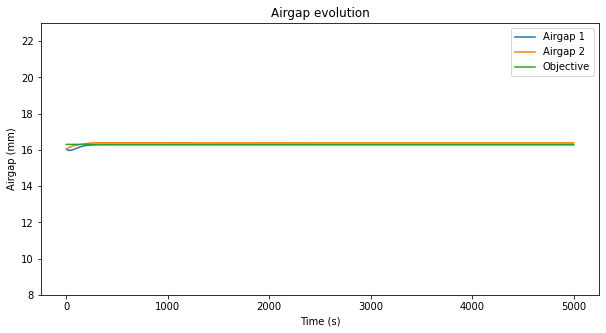

[-1.89738405 -1.89738405 -1.90985593 -1.90985593  0.          0.        ]
Time predict 11.010957717895508
Time model 54.14965748786926
Episode reward 5085.164422399543
[(0.0, 0.0), (-3.164069, -3.1658902), (-6.1752563, -6.18311), (-8.426977, -8.901212), (-8.409853, -11.240901), (-6.8534856, -11.376057), (-6.816255, -9.379722), (-8.237692, -9.150305), (-8.644356, -10.966119), (-7.740562, -11.248786), (-7.48564, -9.576781), (-8.3485775, -9.299551), (-8.781268, -10.900178), (-8.262398, -11.140034), (-7.994795, -9.57426), (-8.511251, -9.355651), (-8.882379, -10.896096), (-8.616857, -11.051805), (-8.402154, -9.497198), (-8.67981, -9.3676815), (-8.951798, -10.918067), (-8.858745, -10.972167), (-8.729168, -9.378213), (-8.8344555, -9.329757), (-8.987405, -10.921468), (-9.017642, -10.908052), (-8.990299, -9.261041), (-8.972192, -9.256321), (-8.997995, -10.892039), (-9.107779, -10.847221), (-9.188301, -9.152495), (-9.092057, -9.161376), (-8.995323, -10.832884), (-9.148167, -10.781221), (-9.33134

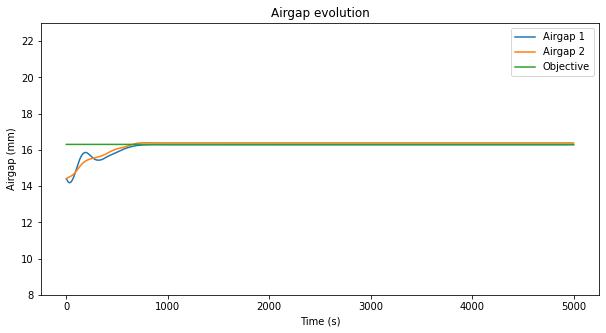

[3.9644522  3.9644522  4.00853292 4.00853292 0.         0.        ]
Time predict 10.983367204666138
Time model 53.55430603027344
Episode reward 5009.15289678796
[(0.0, 0.0), (2.9890947, 2.9890947), (5.9614367, 5.9614367), (8.922431, 8.922433), (11.899023, 11.899073), (14.875142, 14.876423), (17.80063, 17.834454), (20.025728, 20.794306), (19.56478, 23.801697), (18.651884, 26.780455), (20.396507, 29.609205), (23.244396, 32.277466), (24.954046, 34.793884), (22.367104, 37.16083), (20.285934, 39.38478), (22.535046, 41.448174), (23.02417, 42.590027), (19.622972, 40.719326), (18.684986, 38.88265), (21.641277, 39.92443), (22.781881, 40.13845), (19.786663, 37.48644), (18.567184, 36.137043), (21.485367, 37.770187), (21.605999, 37.66679), (18.321634, 34.78078), (17.834408, 33.8512), (20.737175, 35.739296), (21.884657, 35.171986), (18.985428, 31.67284), (17.826899, 30.812027), (20.71557, 32.815723), (21.191368, 32.74322), (18.072184, 29.900745), (17.389074, 27.155521), (20.287355, 26.705978), (23.

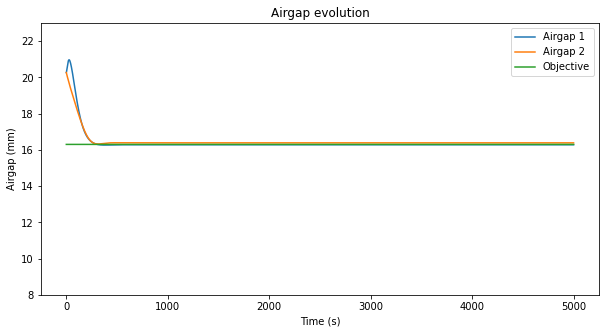

[-4.43030327 -4.43030327 -4.38430115 -4.38430115  0.          0.        ]
Time predict 11.215473890304565
Time model 53.685107946395874
Episode reward 5020.545055656188
[(0.0, 0.0), (-3.245934, -3.245909), (-6.3479867, -6.3479395), (-9.157046, -9.156985), (-11.674131, -11.674063), (-13.955988, -13.955913), (-16.07963, -16.079546), (-18.076551, -18.076384), (-19.960567, -19.96004), (-21.745989, -21.738415), (-23.443457, -23.420532), (-25.066841, -25.016214), (-26.625395, -26.43769), (-28.120987, -27.21652), (-29.54848, -27.067686), (-30.862148, -26.95583), (-31.906393, -27.563112), (-32.55675, -28.300978), (-32.838356, -28.774618), (-32.758232, -29.08875), (-32.394135, -29.338017), (-31.952961, -29.499243), (-31.559998, -29.562193), (-31.21045, -29.566854), (-30.854847, -29.563038), (-30.471577, -29.569801), (-30.072063, -29.578058), (-29.672728, -29.574759), (-29.277224, -29.556644), (-28.879675, -29.52769), (-28.475117, -29.491507), (-28.05947, -29.448227), (-27.636868, -29.395828), (

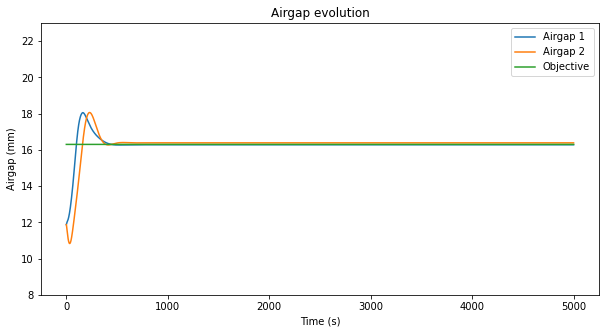

[3.90974443 3.90974443 3.91607754 3.91607754 0.         0.        ]
Time predict 10.74683952331543
Time model 53.620564460754395
Episode reward 5011.988847864538
[(0.0, 0.0), (2.9890947, 2.9890947), (5.9614367, 5.9614367), (8.922433, 8.922433), (11.899073, 11.899073), (14.876423, 14.876423), (17.834454, 17.834454), (20.79427, 20.794306), (23.800627, 23.801697), (26.759895, 26.780455), (29.530437, 29.609146), (31.187653, 32.208336), (28.494453, 32.87796), (26.60484, 31.126104), (29.108768, 30.636513), (30.480005, 31.864227), (27.534023, 30.813953), (25.883001, 29.258818), (28.561735, 30.38984), (29.881958, 31.031382), (26.900057, 28.556866), (25.2301, 27.649782), (27.83885, 30.064672), (29.408278, 29.752768), (26.675829, 26.126724), (23.536049, 25.513876), (24.70458, 28.303328), (27.46166, 30.068628), (27.902027, 27.61919), (24.5881, 24.667871), (22.778906, 25.952473), (24.75459, 28.72548), (27.512302, 27.455566), (26.207907, 22.927135), (21.054144, 22.490625), (20.02587, 25.454716), (2

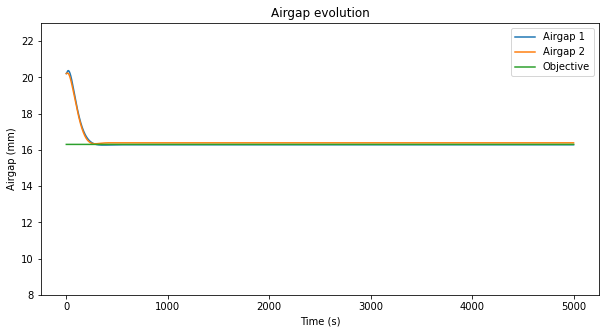

[0.85986743 0.85986743 0.86080048 0.86080048 0.         0.        ]
Time predict 10.77910566329956
Time model 53.37351131439209
Episode reward 5023.874486470954
[(0.0, 0.0), (2.9772835, 3.0267093), (5.259101, 6.0502534), (5.025939, 7.216587), (3.4143388, 5.35134), (3.616597, 4.1890206), (4.7807755, 5.768246), (4.5206428, 6.542098), (3.7018929, 4.764934), (3.8904622, 4.0189905), (4.232097, 5.7195473), (4.1376624, 6.0322747), (4.1692567, 4.035273), (3.8591468, 3.7469833), (3.3133368, 5.7227674), (3.9926822, 5.677166), (4.914089, 3.3788838), (3.738061, 3.2918463), (2.249046, 5.5227036), (3.35018, 5.4700203), (5.311756, 3.0437412), (4.42585, 2.902164), (1.8045673, 5.1592374), (2.106496, 5.1993556), (4.791938, 2.846777), (4.7194633, 2.6519463), (1.9676546, 4.8160834), (1.8790487, 4.8535767), (4.4881372, 2.5759351), (4.5296364, 2.4190245), (1.8892218, 4.5329566), (1.7828355, 4.5260983), (4.3303094, 2.2862582), (4.3301954, 2.164331), (1.7076629, 4.2691445), (1.6337868, 4.2713747), (4.171553, 

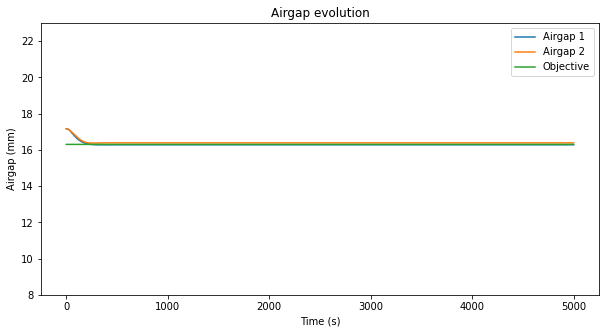

[-0.91302696 -0.91302696 -0.88307944 -0.88307944  0.          0.        ]
Time predict 10.986451148986816
Time model 53.4820442199707
Episode reward 5074.230169965651
[(0.0, 0.0), (-3.1065652, -3.1115866), (-6.063289, -5.8929276), (-8.747589, -6.0139666), (-11.176936, -3.80737), (-12.355932, -3.833257), (-11.275426, -6.109778), (-9.5796385, -6.2307134), (-9.568235, -4.0700583), (-10.46379, -3.9745326), (-10.067737, -6.1227036), (-8.751318, -6.2416387), (-8.471633, -4.1491156), (-9.0681305, -4.0651484), (-8.846352, -6.160703), (-7.85823, -6.2306223), (-7.557811, -4.1399846), (-7.9355397, -4.084223), (-7.7574925, -6.175654), (-7.0289216, -6.20936), (-6.790357, -4.100667), (-7.0132113, -4.0606685), (-6.8273025, -6.1594486), (-6.307516, -6.173832), (-6.171577, -4.049065), (-6.278655, -4.0163755), (-6.044819, -6.122252), (-5.689261, -6.125584), (-5.674201, -3.9892874), (-5.69405, -3.961537), (-5.396792, -6.0738387), (-5.1811686, -6.069884), (-5.3083715, -3.9252503), (-5.2826858, -3.9027462)

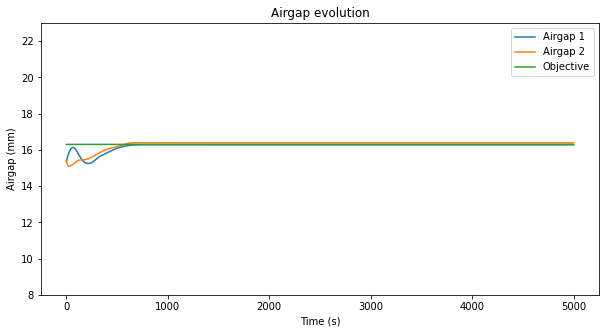

[-4.9265432  -4.9265432  -4.92680909 -4.92680909  0.          0.        ]
Time predict 10.810559034347534
Time model 53.718002796173096
Episode reward 4999.142595561948
[(0.0, 0.0), (-3.267957, -3.267923), (-6.4028206, -6.40276), (-9.252628, -9.252553), (-11.810808, -11.810724), (-14.111861, -14.111772), (-16.228483, -16.228388), (-18.216791, -18.216684), (-20.089262, -20.08915), (-21.85826, -21.85814), (-23.536928, -23.536806), (-25.137335, -25.137186), (-26.670864, -26.670322), (-28.147013, -28.142385), (-29.56962, -29.528257), (-30.942484, -30.63254), (-32.26957, -30.918203), (-33.55253, -30.570036), (-34.79119, -30.6541), (-35.984753, -31.287458), (-37.130424, -31.719852), (-38.218914, -31.666098), (-39.22511, -31.609938), (-40.098022, -31.916958), (-40.80558, -32.29501), (-41.3822, -32.461887), (-41.80071, -32.52827), (-42.000694, -32.65089), (-42.025684, -32.793915), (-41.964134, -32.88891), (-41.88128, -32.9068), (-41.796276, -32.861042), (-41.70274, -32.78108), (-41.592823, -32

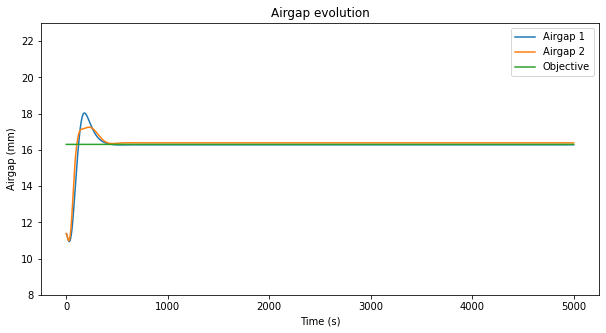

[-4.98248301 -4.98248301 -5.03429441 -5.03429441  0.          0.        ]
Time predict 10.813217401504517
Time model 53.22837781906128
Episode reward 4999.875502779554
[(0.0, 0.0), (-3.267957, -3.2679226), (-6.4028206, -6.4027615), (-9.252628, -9.252556), (-11.810808, -11.810728), (-14.11186, -14.111779), (-16.228477, -16.228401), (-18.215143, -18.21671), (-20.085482, -20.089184), (-21.853725, -21.858181), (-23.531809, -23.536846), (-25.131598, -25.147224), (-26.664618, -26.702456), (-28.140676, -28.201603), (-29.563599, -29.6411), (-30.936892, -30.95481), (-32.25016, -31.703287), (-33.506226, -31.395168), (-34.721703, -30.94344), (-35.89828, -31.32268), (-37.03755, -31.936872), (-38.140835, -31.954271), (-39.209198, -31.596127), (-40.24381, -31.665781), (-41.245327, -32.10224), (-42.21229, -32.249203), (-43.137177, -32.01057), (-43.994644, -31.93041), (-44.729435, -32.223442), (-45.0, -32.54826), (-45.0, -32.575665), (-45.0, -32.32434), (-45.0, -32.112217), (-45.0, -32.08906), (-45.0,

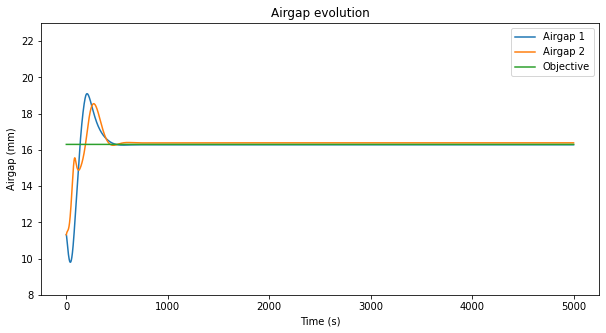

[-1.97616941 -1.97616941 -1.94467036 -1.94467036  0.          0.        ]
Time predict 11.335583209991455
Time model 53.601999282836914
Episode reward 5084.297805356572
[(0.0, 0.0), (-3.1651044, -3.1657503), (-6.1817937, -6.182807), (-8.900739, -8.895502), (-11.374859, -10.916309), (-13.669951, -10.530461), (-15.56055, -8.679672), (-15.673188, -8.96917), (-14.093393, -10.898043), (-13.406465, -10.867344), (-14.181152, -8.998927), (-14.518289, -8.994989), (-13.634753, -10.848028), (-12.921434, -10.956384), (-13.2435055, -9.198939), (-13.523102, -9.112725), (-12.927192, -10.858586), (-12.298369, -10.967743), (-12.415501, -9.271532), (-12.568156, -9.186219), (-12.059628, -10.877526), (-11.506665, -10.949411), (-11.528622, -9.264504), (-11.567441, -9.198893), (-11.086474, -10.873237), (-10.611946, -10.9059105), (-10.618882, -9.2065935), (-10.603735, -9.157196), (-10.158037, -10.833164), (-9.778615, -10.838883), (-9.811357, -9.119424), (-9.74955, -9.0785), (-9.305809, -10.761485), (-9.00699

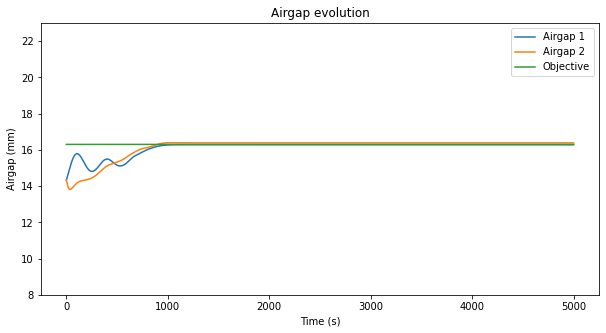

In [11]:
import numpy as np
import torch as th
import time

MODEL_PATH = f"models/2gdl8x8fs-passalis13a19/model.zip"

# Create and wrap the environment
env = TestAngleEnv(duration = 5)

# Load the trained agent
model = SAC.load(MODEL_PATH, env=env, learning_rate = 0.00001)

# Evaluate the agent
for i in range(10):
    obs, seed = env.reset()
    print(obs)
    done = False
    episode_reward = 0
    velocidad = 0
    current = 0
    observations = []
    noises = []
    timepredict = 0
    timemodel = 0
    distancia11, distancia12, distancia21, distancia22, current1, current2 = obs
    while not done:
        #noise = random.uniform(-1, 1)
        #obs = obs + noise
        observations.append(obs)
        #noises.append(noise)
        t1 = time.time()
        action, _states = model.predict(np.array([distancia11, distancia12, distancia21, distancia22, current1, current2]), deterministic=True)
        t2 = time.time()
        #print(action)
        #if env.airgap > 10.1: action = max(action, [-50])
        #print(action)
        t3 = time.time()
        state, reward, terminated, truncated, info = env.step(np.array(action))
        t4 = time.time()
        distancia11, distancia12, distancia21, distancia22, current1, current2 = state
        done = truncated or terminated
        episode_reward += reward
        timepredict += t2 - t1
        timemodel += t4 - t3
        noises.append((current1, current2))
    print("Time predict", timepredict)
    print("Time model", timemodel)
    print("Episode reward", episode_reward)
    print(noises)
    env.render("yes", normalize = True, seed = f"speedpassalis{i}")

In [167]:
import torch as th

from stable_baselines3 import SAC

#import onnx
import onnxruntime as ort
import numpy as np


class OnnxablePolicy(th.nn.Module):
    def __init__(self, actor: th.nn.Module):
        super().__init__()
        # Removing the flatten layer because it can't be onnxed
        self.actor = th.nn.Sequential(
            actor.latent_pi,
            actor.mu,
            # For gSDE
            # th.nn.Hardtanh(min_val=-actor.clip_mean, max_val=actor.clip_mean),
            # Squash the output
            th.nn.Tanh(),
        )

    def forward(self, observation: th.Tensor) -> th.Tensor:
        # NOTE: You may have to process (normalize) observation in the correct
        #       way before using this. See `common.preprocessing.preprocess_obs`
        return self.actor(observation)


# Example: model = SAC("MlpPolicy", "Pendulum-v1")
model = SAC.load(f"models/sac8x8h9.3/model.zip", device="cpu")
onnxable_model = OnnxablePolicy(model.policy.actor)

observation_size = model.observation_space.shape
dummy_input = th.randn(1, *observation_size)
th.onnx.export(
    onnxable_model,
    dummy_input,
    "./ONNX/1gdlComplexH98x8.onnx",
    opset_version=9,
    input_names=["input"],
)

##### Load and test with onnx

import onnxruntime as ort
import numpy as np

onnx_path = "./ONNX/1gdlComplexH98x8.onnx"

observation = np.zeros((1, *observation_size)).astype(np.float32)
ort_sess = ort.InferenceSession(onnx_path)
action = ort_sess.run(None, {"input": observation})

============== Diagnostic Run torch.onnx.export version 2.0.0+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



: 

In [7]:
MODEL_PATH = f"models5gdl/onlyzposlookup copy 3/model.zip"

# Create and wrap the environment
env = Env_5dof(duration = 5)

# Load the trained agent
model = SAC.load(MODEL_PATH, env=env, learning_rate = 0.00001)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [46]:
import torch
list(x*0 for x in model.policy.actor.parameters())
list(model.policy.actor.named_parameters())
model.policy.actor.latent_pi[0].weight = torch.nn.Parameter(model.policy.actor.latent_pi[0].weight *0)
#model.policy.actor.features_extractor.flatten.weight
#model.policy.actor.latent_pi[1].weight
model.policy.actor.latent_pi[2].weight = torch.nn.Parameter(model.policy.actor.latent_pi[2].weight*0)
#model.policy.actor.latent_pi[3].weight
model.policy.actor.mu.weight = torch.nn.Parameter(model.policy.actor.mu.weight *0)
model.policy.actor.log_std.weight = torch.nn.Parameter(model.policy.actor.log_std.weight *0)
model.policy.actor

Actor(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (latent_pi): Sequential(
    (0): Linear(in_features=26, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (mu): Linear(in_features=64, out_features=10, bias=True)
  (log_std): Linear(in_features=64, out_features=10, bias=True)
)

In [37]:
model.policy.actor.log_std.weight

In [ ]:
# See "ONNX export" for imports and OnnxablePolicy
jit_path = "1gdlComplex.pt"

# Trace and optimize the module
traced_module = th.jit.trace(onnxable_model.eval(), dummy_input)
frozen_module = th.jit.freeze(traced_module)
frozen_module = th.jit.optimize_for_inference(frozen_module)
th.jit.save(frozen_module, jit_path)

##### Load and test with torch

import torch as th

dummy_input = th.randn(1, *observation_size)
loaded_module = th.jit.load(jit_path)
action_jit = loaded_module(dummy_input)